<a href="https://colab.research.google.com/github/MDankloff/ClusterCompas/blob/main/Kmeans_Bafv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')
! cd '/content/drive/MyDrive/Mirthe_Supervision /Paper#2/Colab Notebooks'

Mounted at /content/drive


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random
random.seed(42)
import os
import math
import scipy.stats as stats
from scipy.stats import chi2_contingency
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy import stats
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
from google.colab import files
import re

import warnings
warnings.filterwarnings('ignore')

# UTILS

Set of Features (aka data columns)

In [3]:
#Master dataset
#FEATURES
META = ['clusters', 'new_clusters']
ERROR = ['errors', 'TP', 'TN', 'FN', 'FP']
REG = [ 'session_length_in_minutes', 'email_is_free',
       'proposed_credit_limit','name_email_similarity',
      'zip_count_4w', 'date_of_birth_distinct_emails_4w',
      'phone_mobile_valid', 'has_other_cards', 'foreign_request']
SEN = ['customer_age', 'income'] #protected attributes in BAF paper also employment_status
DUMMY = ['source_INTERNET', 'source_TELEAPP', 'device_os_other', 'device_os_macintosh','device_os_linux','device_os_windows', 'device_os_x11']

#FEATURES SCALED
ERROR_scaled = ['errors_scaled']
REG_scaled = ['session_length_in_minutes_scaled',
              'email_is_free_scaled',
              'proposed_credit_limit_scaled',
              'name_email_similarity_scaled',
              'zip_count_4w_scaled',
              'date_of_birth_distinct_emails_4w_scaled','has_other_cards_scaled', 'foreign_request_scaled']
SEN_scaled = ['customer_age_scaled', 'income_scaled']
DUMMY_scaled = ['source_INTERNET_scaled', 'source_TELEAPP_scaled', 'device_os_other_scaled', 'device_os_macintosh_scaled', 'device_os_linux_scaled', 'device_os_windows_scaled', 'device_os_x11_scaled']


#SHAP FEATURES
SHAP_REG = [
    'Shap_session_length_in_minutes', 'Shap_email_is_free',
    'Shap_proposed_credit_limit', 'Shap_name_email_similarity',
    'Shap_zip_count_4w', 'Shap_date_of_birth_distinct_emails_4w',
    'Shap_phone_mobile_valid', 'Shap_has_other_cards', 'Shap_foreign_request'
]

SHAP_SEN = ['Shap_customer_age', 'Shap_income']

SHAP_DUMMY = [
    'Shap_source_INTERNET', 'Shap_source_TELEAPP',
    'Shap_device_os_other', 'Shap_device_os_macintosh',
    'Shap_device_os_linux', 'Shap_device_os_windows', 'Shap_device_os_x11'
]

#SHAP FEATURES SCALED
SHAP_REG_scaled = ['Shap_session_length_in_minutes_scaled',
    'Shap_email_is_free_scaled', 'Shap_proposed_credit_limit_scaled',
    'Shap_name_email_similarity_scaled', 'Shap_zip_count_4w_scaled',
    'Shap_date_of_birth_distinct_emails_4w_scaled',
    'Shap_phone_mobile_valid_scaled', 'Shap_has_other_cards_scaled',
    'Shap_foreign_request_scaled'
]

SHAP_SEN_scaled = ['Shap_customer_age_scaled', 'Shap_income_scaled']

SHAP_DUMMY_scaled = [
    'Shap_source_INTERNET_scaled', 'Shap_source_TELEAPP_scaled',
    'Shap_device_os_other_scaled', 'Shap_device_os_macintosh_scaled',
    'Shap_device_os_linux_scaled', 'Shap_device_os_windows_scaled',
    'Shap_device_os_x11_scaled'
]

'''removed features = 'device_fraud_count', 'intended_balcon_amount', 'payment_type', 'days_since_request',
'velocity_6h', 'velocity_24h', 'velocity_4w', 'keep_alive_session', 'prev_address_months_count', 'current_address_months_count', 'phone_home_valid',
'bank_months_count', 'device_distinct_emails_8w', 'housing_status', 'employment_status, 'bank_branch_count_8w', 'credit_risk_score', 'month', '''

"removed features = 'device_fraud_count', 'intended_balcon_amount', 'payment_type', 'days_since_request',\n'velocity_6h', 'velocity_24h', 'velocity_4w', 'keep_alive_session', 'prev_address_months_count', 'current_address_months_count', 'phone_home_valid',\n'bank_months_count', 'device_distinct_emails_8w', 'housing_status', 'employment_status, 'bank_branch_count_8w', 'credit_risk_score', 'month', "

# Utils for Data prep

In [4]:
#Seperate TPFN & TNFP dataset
'''Drop rows where both TP and FN are 0 '''
def subset_TP_FN(data):
    return data.loc[(data['TP'] == 1) | (data['FN'] == 1)]

'''Drop rows where both TN and FP are 0'''
def subset_TN_FP(data):
    return data.loc[(data['TN'] == 1) | (data['FP'] == 1)]

'''undo Dummy for DUMMY_source or DUMMY_device'''
def undo_dummy(data, with_Dummy, col_label, numeric_values=True, short_label=None):
  data[col_label] = ''
  for i, c in enumerate(with_Dummy):
    values = np.sort(data[c].unique())
    if numeric_values:
      data.loc[data[c] == values[1], col_label] = i
    else:
      if short_label is None:
        raise ValueError("short label must be provided if numeric_values is False")
        data.loc[data[c] == values[1], col_label] = short_label[i]
    data = data.drop(c, axis=1)
  return(data)

#data = undo_dummy(data, DUMMY_RACE, col_label='race', numeric_values=False, short_label=SHORT_LABEL_RACE)
#data = undo_dummy(data, DUMMY_GENDER, col_label='gender', numeric_values=False, short_label=SHORT_LABEL_GENDER)


# Utils for Clustering

In [5]:
# Calculate average (unscaled) Error rate by counting the amount of max values (1) and dividing them by the total nr of rows
# Does not work on scaled (binary) error features
def get_error_rate(data, column='errors'):
  if len(data) == 0:
    print ('calculating error rate on an empty set')
    return
  max_value = data[column].max()
  count_max_value = (data[column] == max_value).sum()
  average_error_rate = count_max_value / len(data)
  return average_error_rate


def get_next_cluster(data, cluster_col, min_size, all_cluster_ids, banned_clusters):
  if(len(banned_clusters) != 0):
    filter_tf = np.isin(all_cluster_ids, banned_clusters, invert=True)
    all_cluster_ids = all_cluster_ids[filter_tf]

  for candidate_cluster_id in all_cluster_ids:
    if candidate_cluster_id == -1:
      continue

    #print ('This is the next cluster:', candidate_cluster_id)

    candidate_cluster = data.loc[data[cluster_col] == candidate_cluster_id]

    if len(candidate_cluster) < min_size:
      #print('...it is too small:', len(candidate_cluster))
      continue
    else:
      return(candidate_cluster_id)

  #print('No suitable clusters were found!')
  return(-1)


# Utils for Results

make recap

In [6]:
def make_recap(data_result, feature_set):
    # Make recap of cluster info with error rates
    res = data_result[['clusters', 'errors']]

    # Cluster size
    temp = data_result[['clusters']].copy()
    temp['count'] = 1
    recap = temp.groupby(['clusters'], as_index=False).sum()

    # Number of errors
    recap['n_error'] = res.groupby(['clusters']).sum().astype(int)

    # Error rate calculation
    recap['error_rate'] = res.groupby(['clusters']).mean()

    # Quality metrics preparation
    diff_vs_rest = []
    diff_p = []

    age_prop = []
    age_diff = []
    age_p = []

    income_prop = []
    income_diff = []
    income_p = []

    silhouette = []

    # Calculate silhouette scores
    clusters = data_result['clusters']
    if len(recap['clusters'].unique()) > 1:
        silhouette_val = silhouette_samples(data_result[feature_set], clusters)

    for c in recap['clusters']:
        # In-cluster data
        c_data = data_result.loc[data_result['clusters'] == c]
        c_count = recap['count'][c]

        # Out-of-cluster data
        rest_data = data_result.loc[data_result['clusters'] != c]
        if len(rest_data) == 0:
            diff_vs_rest.extend([np.nan] * 2)
            age_prop.extend([np.nan] * 3)
            income_prop.extend([np.nan] * 3)
            silhouette.append(np.nan)
            continue

        # Add silhouette score
        silhouette.append(silhouette_val[clusters == c].mean())

        rest_recap = recap.loc[recap['clusters'] != c]
        rest_count = rest_recap['count'].sum()

        # Error rate difference
        rest_n_error = rest_recap['n_error'].sum()
        rest_rate = rest_n_error / rest_count
        diff_vs_rest.append(recap['error_rate'][c] - rest_rate)

        # Poisson stat test for errors
        if any(x < 1 for x in [recap['n_error'][c], recap['count'][c], rest_n_error, rest_count]):
            res = stats.poisson_means_test(recap['count'][c] - recap['n_error'][c], recap['count'][c],
                                           rest_count - rest_n_error, rest_count)
        else:
            res = stats.poisson_means_test(recap['n_error'][c], recap['count'][c], rest_n_error, rest_count)
        diff_p.append(round(res.pvalue, 3))

        #### Sensitive features (age, income)
        # Age feature (customer_age)

        t_stat, p_val = stats.ttest_ind(c_data['customer_age'], rest_data['customer_age'], equal_var = False)

        '''old for poisson
        rest_n_age = rest_data['customer_age'].sum()
        rest_prop_age = rest_n_age / rest_count
        c_n_age = c_data['customer_age'].sum()
        c_prop_age = c_n_age / c_count
        '''

        rest_mean_age = rest_data['customer_age'].mean()
        rest_prop_age = rest_mean_age / rest_count
        c_mean_age = c_data['customer_age'].mean()
        c_prop_age = c_mean_age / c_count

        '''if any(x < 1 for x in [c_mean_age, c_count, rest_mean_age, rest_count]):
            res = stats.poisson_means_test(c_count - c_mean_age, c_count, rest_count - rest_mean_age, rest_count)
        else:
            res = stats.poisson_means_test(c_mean_age, c_count, rest_mean_age, rest_count)
        age_p.append(round(res.pvalue, 3))'''

        if c_data['customer_age'].size > 1 and rest_data['customer_age'].size > 1:
          t_stat, p_val = ttest_ind(c_data['customer_age'], rest_data['customer_age'], equal_var = False)
          age_p.append(round(p_val, 3))
        else:
            age_p.append(np.nan)

        age_prop.append(c_prop_age)
        age_diff.append(c_prop_age - rest_prop_age)


        # Income feature (income)

        t_stat, p_val = stats.ttest_ind(c_data['income'], rest_data['income'], equal_var = False)

        '''old for poisson
        rest_n_income = rest_data['income'].sum()
        rest_prop_income = rest_n_income / rest_count
        c_n_income = c_data['income'].sum()
        c_prop_income = c_n_income / c_count
        '''

        rest_mean_income = rest_data['income'].mean()
        rest_prop_income = rest_mean_income / rest_count
        c_mean_income = c_data['income'].mean()
        c_prop_income = c_mean_income / c_count

        print('c_n_income:', c_mean_income)
        print('c_count:', c_count)
        print('rest_n_income:', rest_mean_income)
        print('rest_count:', rest_count)

        if c_data['income'].size > 1 and rest_data['income'].size > 1:
          t_stat, p_val = ttest_ind(c_data['income'], rest_data['income'], equal_var = False)
          income_p.append(round(p_val, 3))
        else:
          income_p.append(np.nan)

        income_prop.append(c_prop_income)
        income_diff.append(c_prop_income - rest_prop_income)

        '''if any(x < 1 for x in [c_mean_income, c_count, rest_mean_income, rest_count]):
            res = stats.poisson_means_test(c_count - c_mean_income, c_count, rest_count - rest_mean_income, rest_count)
            #res = stats.ttest_ind()
        else:
            res = stats.poisson_means_test(c_mean_income, c_count, rest_mean_income, rest_count)
        income_p.append(round(res.pvalue, 3))'''


    # Populate recap DataFrame with results
    recap['diff_vs_rest'] = np.around(diff_vs_rest, 3)
    recap['diff_p'] = diff_p
    recap['age_prop'] = np.around(age_prop, 3)
    recap['age_diff'] = np.around(age_diff, 3)
    recap['age_p'] = age_p
    recap['income_prop'] = np.around(income_prop, 3)
    recap['income_diff'] = np.around(income_diff, 3)
    recap['income_p'] = income_p
    recap['silhouette'] = silhouette
    recap['error_rate'] = np.around(recap['error_rate'], 3)

    # Rename columns for clarity
    recap.rename(columns={'clusters': 'c'}, inplace=True)

    return recap


## Chi-Square Tests

In [7]:
def make_chi_tests(results):
  chi_res = {'cond_descr': [],
            'cond_name': [],
            'error': [],
            'age': [],
            'income': []}

  for i in range(0, len(results['cond_name'])):
    chi_res['cond_descr'].append(results['cond_descr'][i])
    chi_res['cond_name'].append(results['cond_name'][i])
    data = results['cond_res'][i]
    recap = results['cond_recap'][i]

    if(len(recap['diff_p']) == 1):
      chi_res['error'].append(np.nan)
      chi_res['age'].append(np.nan)
      chi_res['income'].append(np.nan)
      continue

    # Test error differences
    test_data = recap[['count', 'n_error']].copy(deep=True)

    test_data['count'] = test_data['count'] - test_data['n_error']
    test_data = test_data.rename(columns={"count": "n_correct"})

    test_data = test_data.transpose()
    test_res = chi2_contingency(test_data)
    chi_res['error'].append(round(test_res.pvalue, 6))

    #print(test_data)
    # print(round(test_res.pvalue, 6))

    # Test income differences
    test_data = recap[['count', 'income_prop']].copy(deep=True)

    test_data['income_prop'] = round(test_data['count'] * test_data['income_prop'])
    test_data = test_data.rename(columns={"income_prop": "income_n"}).astype(int)

    test_data['count'] = test_data['count'] - test_data['income_n']
    test_data = test_data.rename(columns={"count": "income_n"})

    test_data = test_data.transpose()
    test_res = chi2_contingency(test_data)
    chi_res['income'].append(round(test_res.pvalue, 6))

    # print(test_data)
    # print(round(test_res.pvalue, 6))

    # Test age differences
    test_data = recap[['count', 'age_prop']].copy(deep=True)

    test_data['age_prop'] = round(test_data['count'] * test_data['age_prop'])
    test_data = test_data.rename(columns={"age_prop": "age_n"}).astype(int)

    test_data['count'] = test_data['count'] - test_data['age_n']
    test_data = test_data.rename(columns={"count": "age_n"})

    test_data = test_data.transpose()
    test_res = chi2_contingency(test_data)
    chi_res['age'].append(round(test_res.pvalue, 6))

  return(pd.DataFrame(chi_res))


In [8]:
from scipy.stats import f_oneway

def make_anova_tests(results):
  anova_res = {'cond_descr': [],
               'cond_name': [],
               'error': [],
               'age': [],
               'income': []}

  for i in range(0, len(results['cond_name'])):
    anova_res['cond_descr'].append(results['cond_descr'][i])
    anova_res['cond_name'].append(results['cond_name'][i])
    data = results['cond_res'][i]
    recap = results['cond_recap'][i]

    if len(recap['diff_p']) == 1:  # Check if only one cluster
      anova_res['error'].append(np.nan)
      anova_res['age'].append(np.nan)
      anova_res['income'].append(np.nan)
      continue

    # Test error differences (ANOVA)
    groups = [data['errors'][data['clusters'] == c] for c in recap['c']]
    fvalue, pvalue = f_oneway(*groups)  # Perform ANOVA
    anova_res['error'].append(round(pvalue, 6))

    # Test age differences (ANOVA)
    groups = [data['customer_age'][data['clusters'] == c] for c in recap['c']]
    fvalue, pvalue = f_oneway(*groups)  # Perform ANOVA
    anova_res['age'].append(round(pvalue, 6))

    # Test income differences (ANOVA)
    groups = [data['income'][data['clusters'] == c] for c in recap['c']]
    fvalue, pvalue = f_oneway(*groups)  # Perform ANOVA
    anova_res['income'].append(round(pvalue, 6))

  return pd.DataFrame(anova_res)

## All Quality Metrics

In [12]:
def recap_quali_metrics(chi_res, results, exp_condition):
  all_quali = {'cond_descr': chi_res['cond_descr'],
            'cond_name': chi_res['cond_name'],
            'error': chi_res['error'],
            'age': anova_res['age'],
            'income': anova_res['income'],
            'silhouette': []}

  for i in range(0, len(chi_res['cond_name'])):
    data = results['cond_res'][i]
    feature_set = exp_condition['feature_set'][i]
    clusters = data['clusters']
    recap = results['cond_recap'][i]
    if(len(recap['diff_p']) == 1):
      all_quali['silhouette'].append(np.nan)
      continue
    silhouette_indiv = silhouette_samples(data[feature_set], clusters)
    silhouette_avg = silhouette_indiv.mean()
    all_quali['silhouette'].append(silhouette_avg)

  return(pd.DataFrame(all_quali))

## Utils for VIZ

In [11]:
def tsne_plot_wClusters(data, title, perplexity, learning_rate, n_iter, alpha, size, tsne_columns, fig_prefix):
  # Extract features for t-SNE and drop other_columns
  tsne_features = data[tsne_columns]
  other_columns = [col for col in data.columns if col not in tsne_features]
  other_features = data[other_columns]

  tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, n_iter=n_iter)
  tsne_result = tsne.fit_transform(tsne_features)
  tsne_df = pd.DataFrame(tsne_result, index = tsne_features.index, columns=['t-SNE Component 1', 't-SNE Component 2'])

  temp_dataset = tsne_df.join(other_features, how='left')

  # Create scatterplot using seaborn
  scatterplot = sns.scatterplot(data=temp_dataset, x='t-SNE Component 1', y='t-SNE Component 2', alpha=alpha, s=size,
                                hue="clusters", palette='tab10', style='Error_Type')
  scatterplot.set_title(title)
  scatterplot.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)

  plt.savefig(fig_prefix+re.sub(' +', '', title)+'.png', bbox_inches='tight', pad_inches=0)
  plt.show()

# K-Means Clustering

In [14]:
def hbac_kmeans(data, columns_to_use=[], error='errors',
                min_splittable_cluster_prop = 0.05,
                min_acceptable_cluster_prop = 0.03,
                min_acceptable_error_diff = 0.01,
                max_iter=300,
                random_state=None):
    clus_model_kwargs = {
        "n_clusters": 2,  # Number of clusters to form
        "init": "k-means++",  # Centroids initialization method
        "n_init": 10,  # Number of initializations
        "max_iter": max_iter,  # Maximum iterations for a single run
    }

    min_splittable_cluster_size = round(min_splittable_cluster_prop * len(data))  # Minimum size of cluster to be split
    min_acceptable_cluster_size = round(min_acceptable_cluster_prop * len(data))  # Minimum acceptable size of cluster after split

    # Initialize loop's variables
    data['clusters'] = 0
    banned_clusters = []

    #### CLUSTERING LOOP
    for i in range(1, max_iter):
      # Init temporary cluster
      data['new_clusters'] = None

      ### Select the cluster to split in 2
      x = get_next_cluster(data, 'clusters', min_splittable_cluster_size, data['clusters'].unique(), banned_clusters)
      if(x == -1):
        break

      candidate_cluster = data.copy(deep=True)
      candidate_cluster = candidate_cluster.loc[candidate_cluster['clusters'] == x]

      #### SPLIT IN 2 SUB-CLUSTERS
      kmeans = KMeans(**clus_model_kwargs, random_state=42).fit(candidate_cluster[columns_to_use])
      candidate_cluster['new_clusters'] = kmeans.labels_

      # KEEP CLUSTER OR NOT
      # ...are cluster size large enough?
      l0 = len(candidate_cluster.loc[candidate_cluster['new_clusters'] == 0])
      l1 = len(candidate_cluster.loc[candidate_cluster['new_clusters'] == 1])

      if((l0 < min_acceptable_cluster_size) | (l1 < min_acceptable_cluster_size)):
        #print('Bad split: too small')
        banned_clusters.append(x)
        continue

      # ...is error rate difference large enough?
      e0 = get_error_rate(candidate_cluster.loc[candidate_cluster['new_clusters'] == 0])
      e1 = get_error_rate(candidate_cluster.loc[candidate_cluster['new_clusters'] == 1])

      if(abs(e0 - e1) < min_acceptable_error_diff):
        #print('Bad split: same error')
        banned_clusters.append(x)
        continue

      ### Re-integrate to main data
      data['new_clusters'] = candidate_cluster['new_clusters'].combine_first(data['new_clusters'])

      # Make new Cluster IDs
      new_id = data['clusters'].unique().max() + 1
      data.loc[((data.clusters == x) & (data.new_clusters == 1)), 'clusters'] = new_id

    #print('Max iterations reached:', i)
    return data

# SETUP EXPERIMENTS

### Prepare Data

In [18]:
v2_all = pd.read_csv('/content/drive/MyDrive/Mirthe_Supervision /Paper#3/BAF/v2_all.csv')

#split into TP/FN and TN/FP
TPFN_data = subset_TP_FN(v2_all)
TNFP_data = subset_TN_FP(v2_all)

# Drop NA's
TPFN_data = TPFN_data.dropna()
TNFP_data = TNFP_data.dropna()


In [20]:
TPFN_data.iloc[3]

,1645
income,0.9
name_email_similarity,0.321542
customer_age,50
zip_count_4w,1042
date_of_birth_distinct_emails_4w,5
...,...
Shap_device_os_linux_scaled,0.817693
Shap_device_os_macintosh_scaled,1.40838
Shap_device_os_other_scaled,0.661763
Shap_device_os_windows_scaled,1.266919


In [36]:
TNFP_data.iloc[3]

,3
income,0.5
name_email_similarity,0.216108
customer_age,70
zip_count_4w,1120
date_of_birth_distinct_emails_4w,3
...,...
Shap_device_os_linux_scaled,0.594038
Shap_device_os_macintosh_scaled,-1.307885
Shap_device_os_other_scaled,-1.860419
Shap_device_os_windows_scaled,-0.816272


### Set experimental conditions

In [21]:
##### HBAC parameters
min_splittable_cluster_prop = 0.05
min_acceptable_cluster_prop = 0.05
min_acceptable_error_diff = 0.005

##### Make and name the sets of features to experiment with
feature_set_name = []
feature_set_descr = []
feature_set = []

######### BASELINE HBAC
### Does adding SHAP help the clustering?
# Baseline (Mitzal-Radheka)
feature_set_name.append(f'+REG +SEN  -err     -shap')
feature_set_descr.append('Baseline')
feature_set.append(REG_scaled + DUMMY_scaled + SEN_scaled)

# Baseline with Error (Selma)
feature_set_name.append('+REG +SEN +ERR  -shap')
feature_set_descr.append('Baseline with Error')
feature_set.append(REG_scaled + DUMMY_scaled + SEN_scaled + ERROR_scaled)

# Adding SHAP values to Baseline (Mirthe;)
feature_set_name.append('+REG +SEN  -err    +SHAP')
feature_set_descr.append('Baseline with SHAP')
feature_set.append(REG_scaled + DUMMY_scaled + SEN_scaled + SHAP_REG_scaled + SHAP_DUMMY_scaled + SHAP_SEN_scaled)

feature_set_name.append('+REG +SEN +ERR  +SHAP')
feature_set_descr.append('Baseline with SHAP & Error')
feature_set.append(REG_scaled + DUMMY_scaled + SEN_scaled + ERROR_scaled + SHAP_REG_scaled + SHAP_DUMMY_scaled + SHAP_SEN_scaled)


############ SHAP-ONLY HBAC
### Does SHAP alone allow to identify clusters?
# Using only SHAP values
feature_set_name.append('-reg    -sen    -err     +SHAP')
feature_set_descr.append('SHAP only')
feature_set.append(SHAP_REG_scaled + SHAP_DUMMY_scaled)

feature_set_name.append('-reg    -sen    +ERR  +SHAP')
feature_set_descr.append('SHAP only with Error')
feature_set.append(SHAP_REG_scaled + SHAP_DUMMY_scaled + ERROR_scaled)


############ ONLY SENSITIVE FEATURES
### Do sensitive features alone allow to identify clusters?
# Using only Sensitive features
feature_set_name.append('-reg    +SEN  -err     -shap')
feature_set_descr.append('Sensitive features only')
feature_set.append(SEN_scaled)

feature_set_name.append('-reg    +SEN +ERR   -shap')
feature_set_descr.append('Sensitive features with Error')
feature_set.append(SEN_scaled + ERROR_scaled)

### Does adding SHAP help the clustering based on sensitive features?
# Using Sensitive features with SHAP values
feature_set_name.append('-reg    +SEN  -err     +SHAP_S')
feature_set_descr.append('Sensitive features with SHAP')
feature_set.append(SEN_scaled + SHAP_SEN_scaled)

feature_set_name.append('-reg    +SEN +ERR  +SHAP_S')
feature_set_descr.append('Sensitive features with SHAP & Error')
feature_set.append(SEN_scaled + SHAP_SEN_scaled + ERROR_scaled)

# Using only SHAP of Sensitive features
feature_set_name.append('-reg    -sen    -err     +SHAP_S')
feature_set_descr.append('Only SHAP of Sensitive features')
feature_set.append(SHAP_SEN_scaled)

feature_set_name.append('-reg    -sen    +ERR  +SHAP_S')
feature_set_descr.append('Only SHAP of Sensitive features')
feature_set.append(SHAP_SEN_scaled + ERROR_scaled)


############ ONLY REGULAR FEATURES
#conditons without sensitive to check how much it explains the results
feature_set_name.append('+REG -sen    -err     -shap')
feature_set_descr.append('REG Only')
feature_set.append(REG_scaled + DUMMY_scaled)

feature_set_name.append('+REG -sen    +ERR  -shap')
feature_set_descr.append('REG & ERROR')
feature_set.append(REG_scaled + DUMMY_scaled + ERROR_scaled)

feature_set_name.append('+REG -sen    -err     +SHAP_R')
feature_set_descr.append('REG & SHAP')
feature_set.append(REG_scaled + DUMMY_scaled + SHAP_REG_scaled) # ERROR FIXED

feature_set_name.append('+REG -sen    +ERR  +SHAP_R')
feature_set_descr.append('REG, ERROR & SHAP')
feature_set.append(REG_scaled + DUMMY_scaled + ERROR_scaled + SHAP_REG_scaled) # ERROR FIXED

# Using only SHAP of Regular features
feature_set_name.append('-reg    -sen    -err     +SHAP_R')
feature_set_descr.append('Only SHAP of Regular features')
feature_set.append(SHAP_REG_scaled)

feature_set_name.append('-reg    -sen    +ERR  +SHAP_R')
feature_set_descr.append('Only SHAP of Regular features + Error')
feature_set.append(SHAP_REG_scaled + ERROR_scaled)

exp_condition = pd.DataFrame({'feature_set_descr': feature_set_descr,
                              'feature_set_name': feature_set_name,
                              'feature_set': feature_set})
exp_condition


,feature_set_descr,feature_set_name,feature_set
0,Baseline,+REG +SEN -err -shap,"[session_length_in_minutes_scaled, email_is_fr..."
1,Baseline with Error,+REG +SEN +ERR -shap,"[session_length_in_minutes_scaled, email_is_fr..."
2,Baseline with SHAP,+REG +SEN -err +SHAP,"[session_length_in_minutes_scaled, email_is_fr..."
3,Baseline with SHAP & Error,+REG +SEN +ERR +SHAP,"[session_length_in_minutes_scaled, email_is_fr..."
4,SHAP only,-reg -sen -err +SHAP,"[Shap_session_length_in_minutes_scaled, Shap_e..."
5,SHAP only with Error,-reg -sen +ERR +SHAP,"[Shap_session_length_in_minutes_scaled, Shap_e..."
6,Sensitive features only,-reg +SEN -err -shap,"[customer_age_scaled, income_scaled]"
7,Sensitive features with Error,-reg +SEN +ERR -shap,"[customer_age_scaled, income_scaled, errors_sc..."
8,Sensitive features with SHAP,-reg +SEN -err +SHAP_S,"[customer_age_scaled, income_scaled, Shap_cust..."
9,Sensitive features with SHAP & Error,-reg +SEN +ERR +SHAP_S,"[customer_age_scaled, income_scaled, Shap_cust..."


#TNFP RESULTS

In [32]:
#TNFP_data.info()

## Execute experiments

In [23]:
# Set global seed
seed_value = 42
np.random.seed(seed_value)
random.seed(seed_value)

results = {'cond_name': [],
           'cond_descr': [],
           'cond_res': [],
           'cond_recap': []}

for i in range(0, len(exp_condition)):
    # Pass seed to ensure reproducibility
    res = hbac_kmeans(TNFP_data.copy(deep=True),
                      columns_to_use=exp_condition['feature_set'][i],
                      error='errors',
                      min_splittable_cluster_prop=min_splittable_cluster_prop,
                      min_acceptable_cluster_prop=min_acceptable_cluster_prop,
                      min_acceptable_error_diff=min_acceptable_error_diff,
                      max_iter=100,
                      random_state=seed_value)  # Assuming hbac_kmeans accepts random_state

    recap = make_recap(res, exp_condition['feature_set'][i])

    results['cond_name'].append(exp_condition['feature_set_name'][i])
    results['cond_descr'].append(exp_condition['feature_set_descr'][i])
    results['cond_res'].append(res)
    results['cond_recap'].append(recap)


c_n_income: 0.6047619047619048
c_count: 546
rest_n_income: 0.6379562043795621
rest_count: 1096
c_n_income: 0.6285714285714286
c_count: 525
rest_n_income: 0.6261414503133393
rest_count: 1117
c_n_income: 0.6513569937369521
c_count: 479
rest_n_income: 0.616852966466036
rest_count: 1163
c_n_income: 0.6217391304347825
c_count: 92
rest_n_income: 0.627225806451613
rest_count: 1550
c_n_income: 0.6047619047619048
c_count: 546
rest_n_income: 0.6379562043795621
rest_count: 1096
c_n_income: 0.6285714285714286
c_count: 525
rest_n_income: 0.6261414503133393
rest_count: 1117
c_n_income: 0.6513569937369521
c_count: 479
rest_n_income: 0.616852966466036
rest_count: 1163
c_n_income: 0.6217391304347825
c_count: 92
rest_n_income: 0.627225806451613
rest_count: 1550
c_n_income: 0.7151260504201683
c_count: 119
rest_n_income: 0.620026263952725
rest_count: 1523
c_n_income: 0.6166952054794521
c_count: 1168
rest_n_income: 0.6521097046413502
rest_count: 474
c_n_income: 0.8906779661016955
c_count: 118
rest_n_income

In [24]:
# Count the number of missing values in each column
missing_counts = TNFP_data.isnull().sum(axis=0)

# Print the result
print(missing_counts)

income                              0
name_email_similarity               0
customer_age                        0
zip_count_4w                        0
date_of_birth_distinct_emails_4w    0
                                   ..
Shap_device_os_linux_scaled         0
Shap_device_os_macintosh_scaled     0
Shap_device_os_other_scaled         0
Shap_device_os_windows_scaled       0
Shap_device_os_x11_scaled           0
Length: 82, dtype: int64


In [25]:
#print(TNFP_data.columns)

Index(['income', 'name_email_similarity', 'customer_age', 'zip_count_4w',
       'date_of_birth_distinct_emails_4w', 'email_is_free',
       'phone_mobile_valid', 'has_other_cards', 'proposed_credit_limit',
       'foreign_request', 'session_length_in_minutes', 'source_INTERNET',
       'source_TELEAPP', 'device_os_linux', 'device_os_macintosh',
       'device_os_other', 'device_os_windows', 'device_os_x11',
       'income_scaled', 'name_email_similarity_scaled', 'customer_age_scaled',
       'zip_count_4w_scaled', 'date_of_birth_distinct_emails_4w_scaled',
       'email_is_free_scaled', 'phone_mobile_valid_scaled',
       'has_other_cards_scaled', 'proposed_credit_limit_scaled',
       'foreign_request_scaled', 'session_length_in_minutes_scaled',
       'source_INTERNET_scaled', 'source_TELEAPP_scaled',
       'device_os_linux_scaled', 'device_os_macintosh_scaled',
       'device_os_other_scaled', 'device_os_windows_scaled',
       'device_os_x11_scaled', 'errors', 'TP', 'TN', 'FN', '

In [26]:
print(DUMMY_scaled)

['source_INTERNET_scaled', 'source_TELEAPP_scaled', 'device_os_other_scaled', 'device_os_macintosh_scaled', 'device_os_linux_scaled', 'device_os_windows_scaled', 'device_os_x11_scaled']


### CHI-Square/ ANOVA Tests TNFP data

In [ ]:
'''chi_res = make_chi_tests(results)
chi_res_viz = chi_res.set_index('cond_name').drop('cond_descr', axis=1)
chi_res_viz = round(chi_res_viz, 6)
chi_res_viz'''

"chi_res = make_chi_tests(results)\nchi_res_viz = chi_res.set_index('cond_name').drop('cond_descr', axis=1)\nchi_res_viz = round(chi_res_viz, 6)\nchi_res_viz"

In [27]:
anova_res = make_anova_tests(results)
anova_res_viz = anova_res.set_index('cond_name').drop('cond_descr', axis=1)
anova_res_viz = round(anova_res_viz, 6)
anova_res_viz

,error,age,income
cond_name,,,
+REG +SEN -err -shap,0.000000,0.000000,0.064439
+REG +SEN +ERR -shap,0.000000,0.000000,0.064439
+REG +SEN -err +SHAP,0.000000,0.000001,0.000000
+REG +SEN +ERR +SHAP,0.000000,0.000001,0.000000
-reg -sen -err +SHAP,0.000000,0.000015,0.000000
-reg -sen +ERR +SHAP,0.000000,0.000015,0.000000
-reg +SEN -err -shap,0.000000,0.000000,0.000000
-reg +SEN +ERR -shap,0.000007,0.000000,0.000000
-reg +SEN -err +SHAP_S,0.000000,0.000000,0.000000


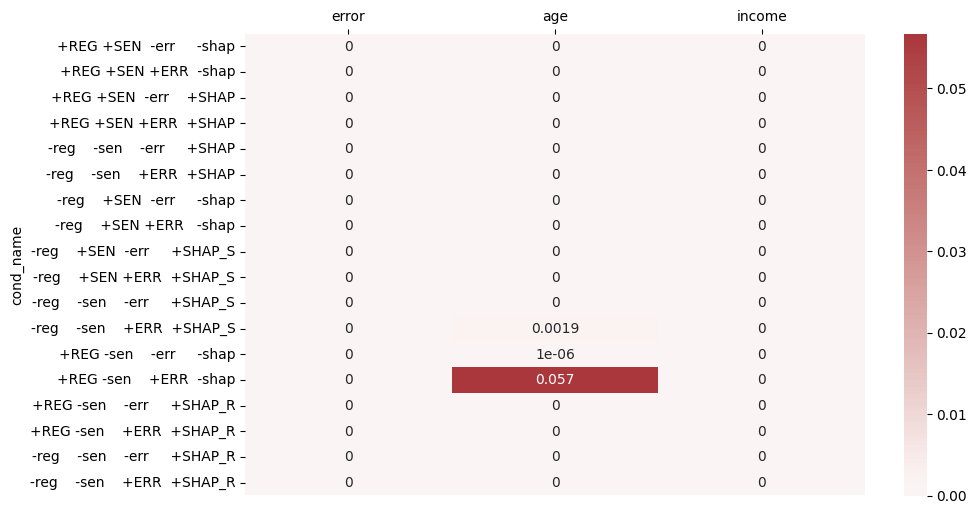

In [38]:
plt.figure(figsize=(10,6))
ax = sns.heatmap(#chi_res_viz,
                 anova_res_viz,annot=True, center=0,
                cmap=sns.color_palette("vlag", as_cmap=True), robust=False)
ax.xaxis.tick_top()
plt.yticks(rotation='horizontal')
plt.show()

### ALL quality metrics TNFP data

In [29]:
all_quali = recap_quali_metrics(#chi_res,
                                anova_res, results, exp_condition)
all_quali_viz = all_quali.set_index('cond_name').drop('cond_descr', axis=1)
all_quali_viz = round(all_quali_viz, 6)
# all_quali_viz

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

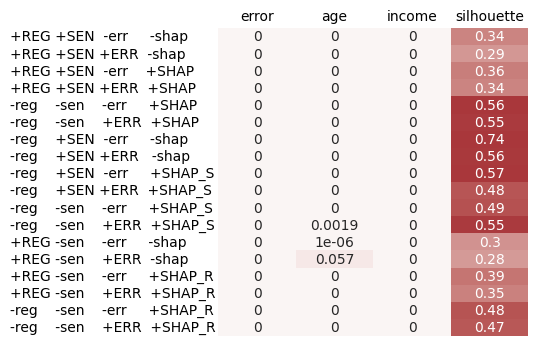

In [43]:
plt.figure(figsize=(4,4))
ax = sns.heatmap(all_quali_viz, annot=True, center=0, cbar=False,
                cmap=sns.color_palette("vlag", as_cmap=True), robust=True)
ax.set(xlabel="", ylabel="")
ax.xaxis.tick_top()
ax.tick_params(axis='x', which='major', length=0)
ax.tick_params(axis='y', which='major', pad=150, length=0)
plt.yticks(ha='left')
plt.savefig('TNFP_Kmeans_BAF.png', bbox_inches='tight', pad_inches=0)
files.download('TNFP_Kmeans_BAF.png')
plt.show()


# Detailed TNFP results

### One-vs-All cluster comparison TNFP data

0


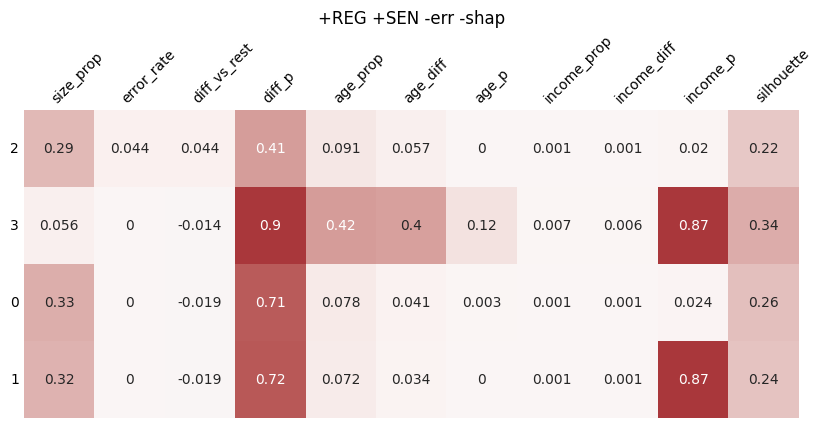

1


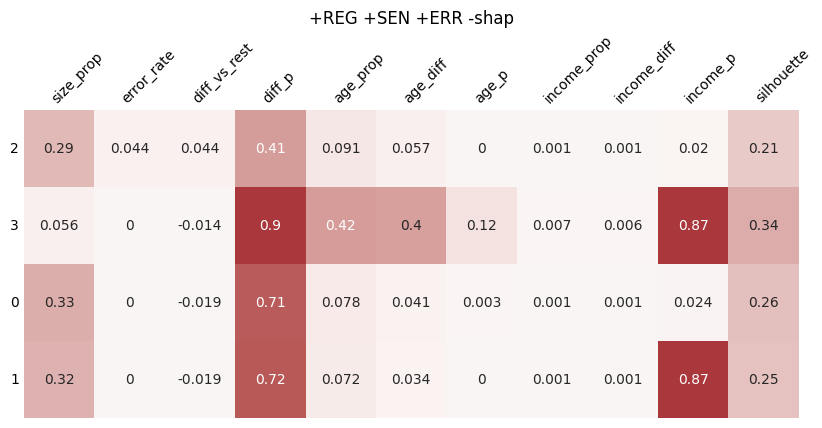

2


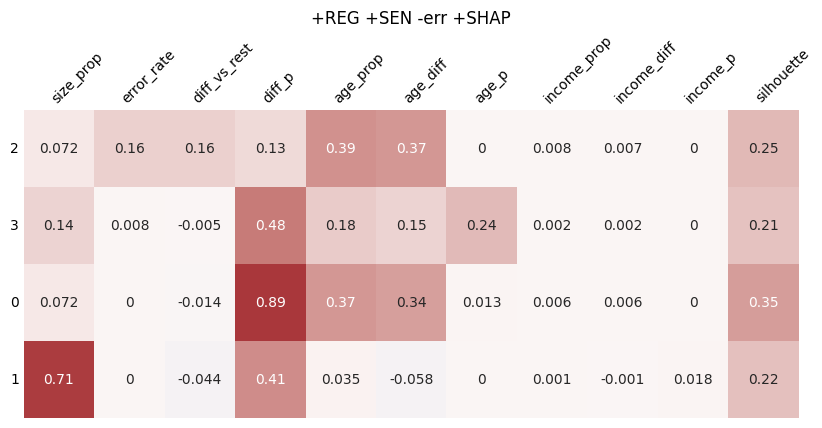

3


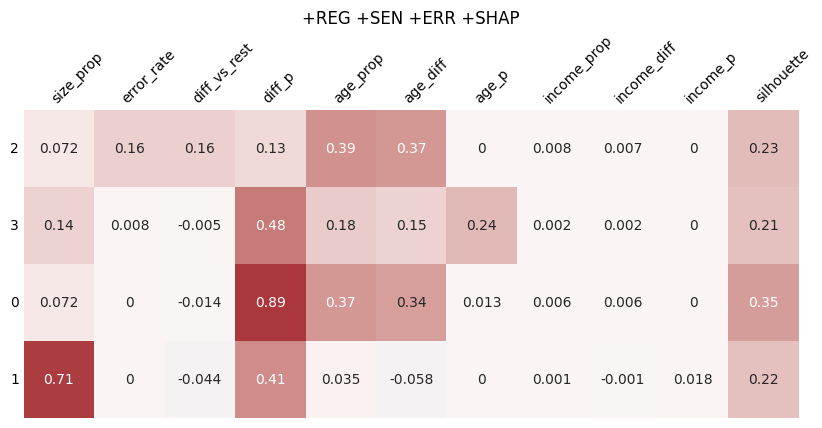

4


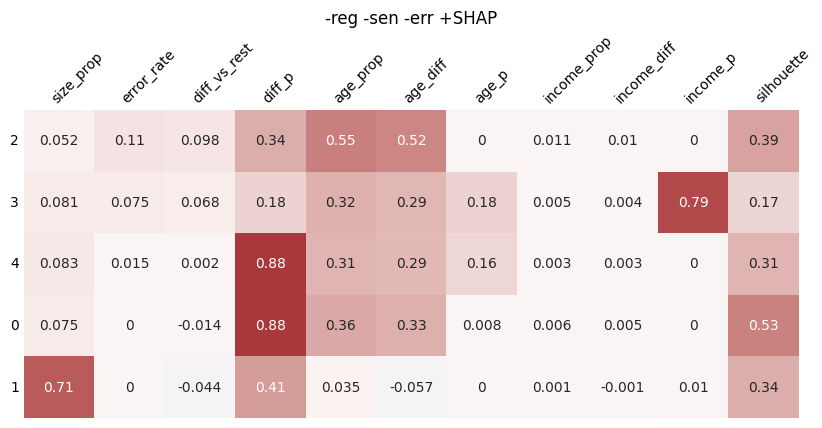

5


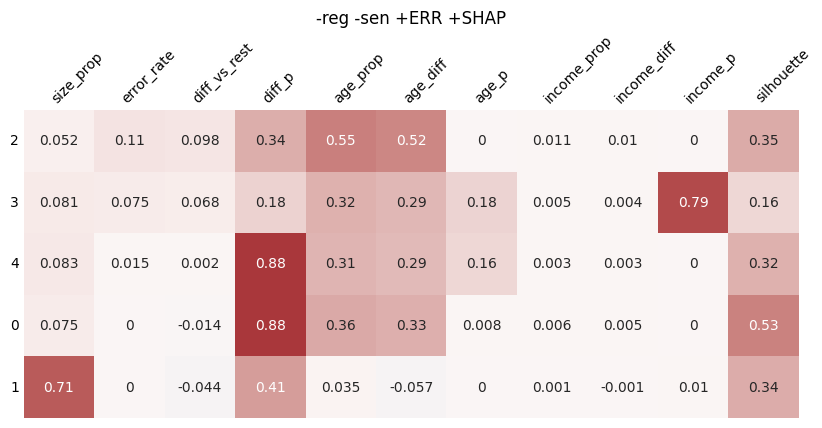

6


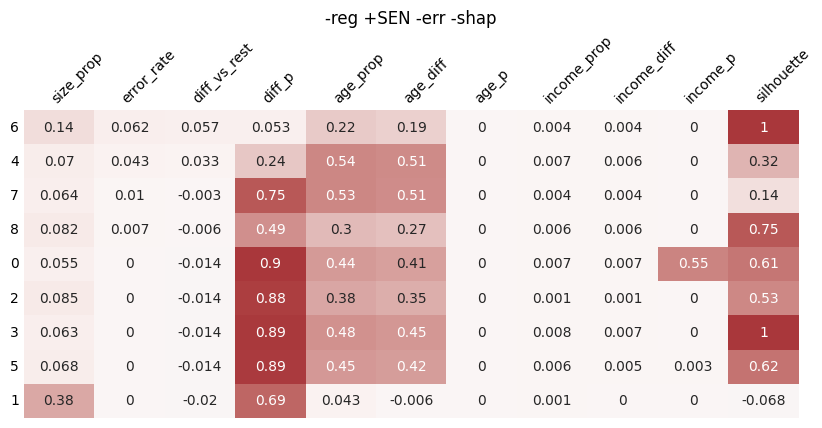

7


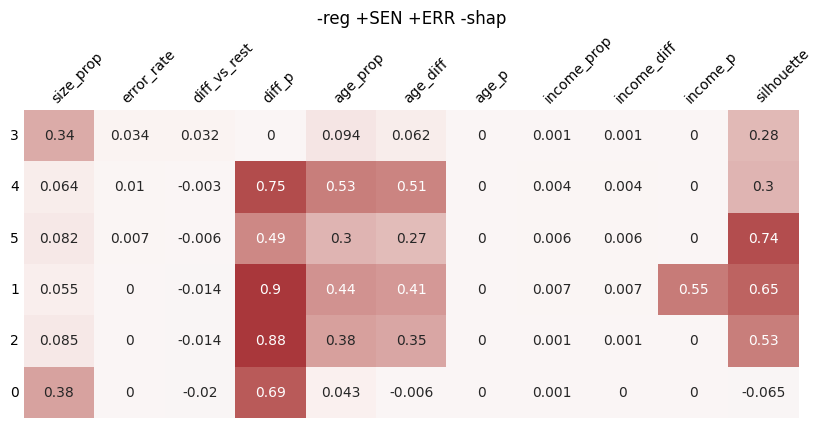

8


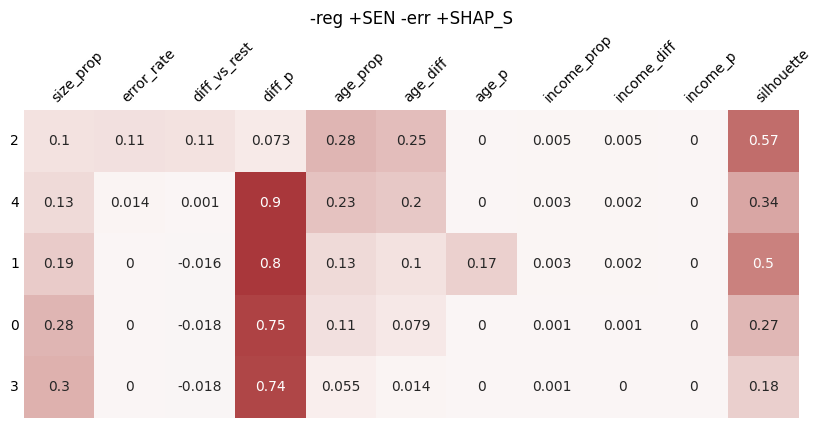

9


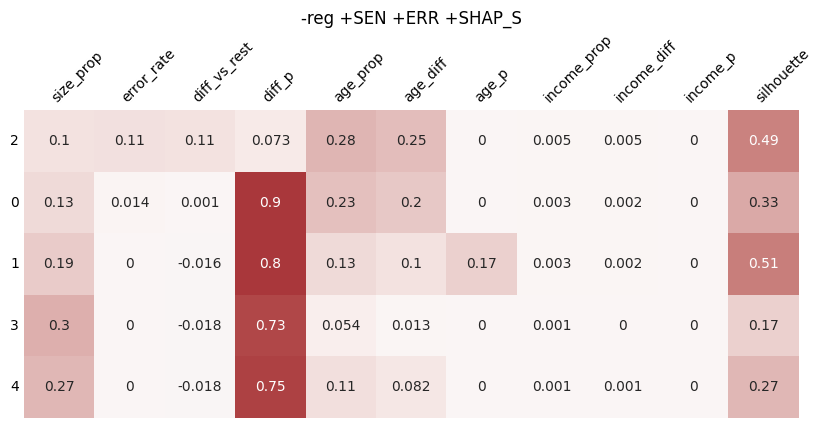

10


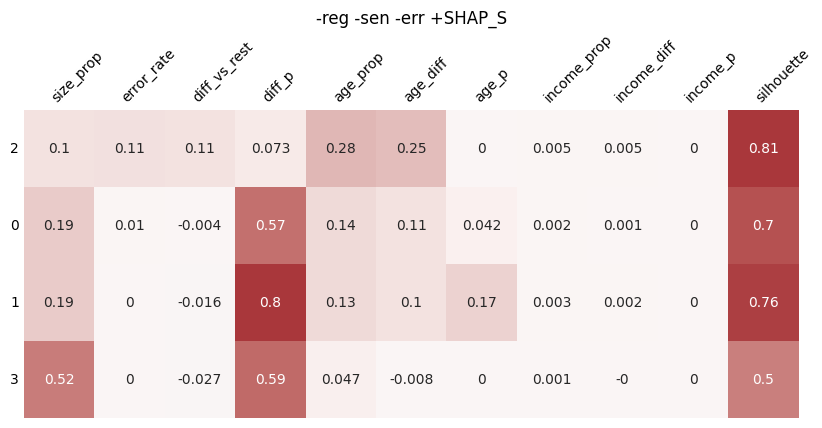

11


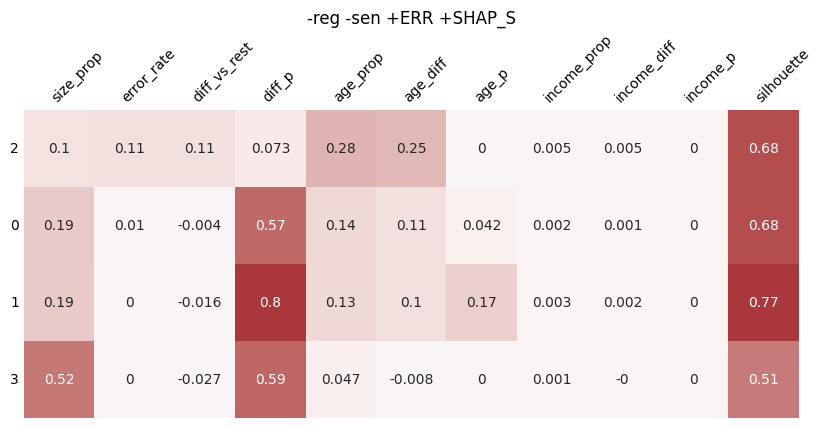

12


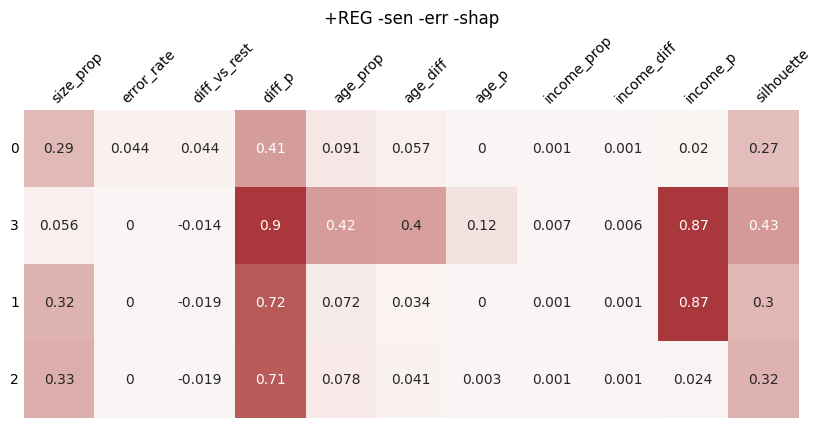

13


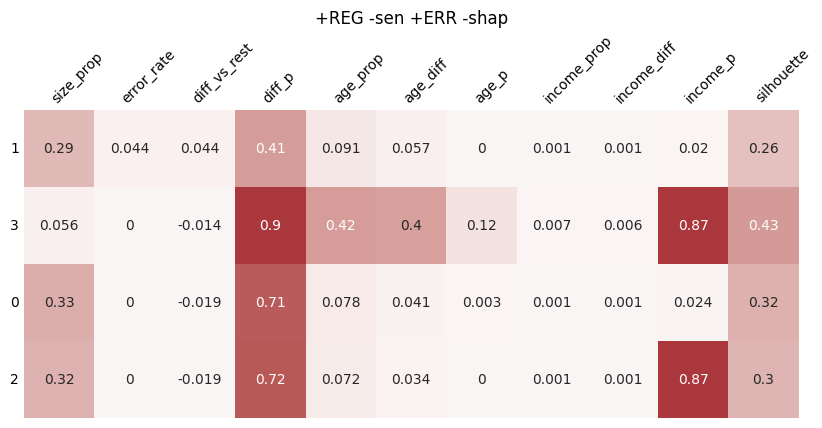

14


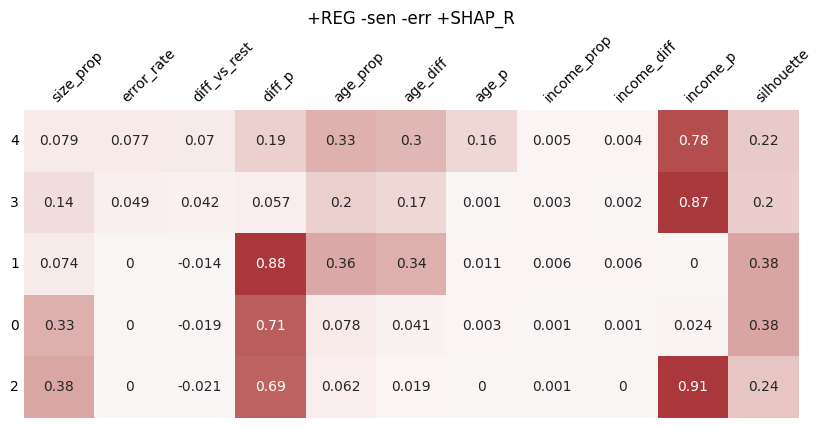

15


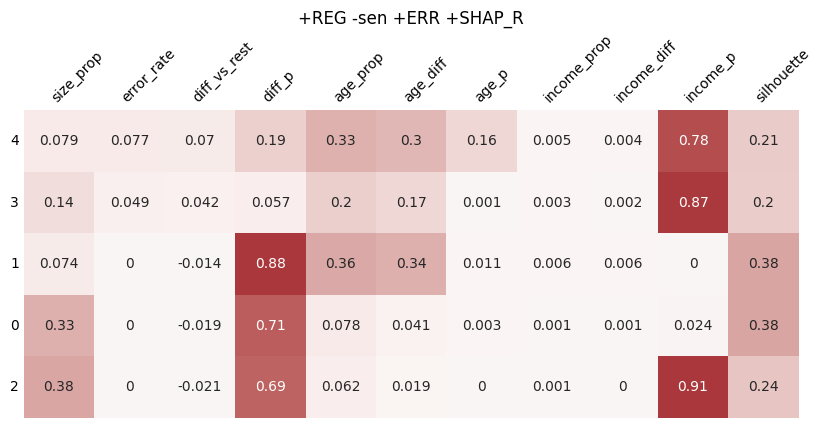

16


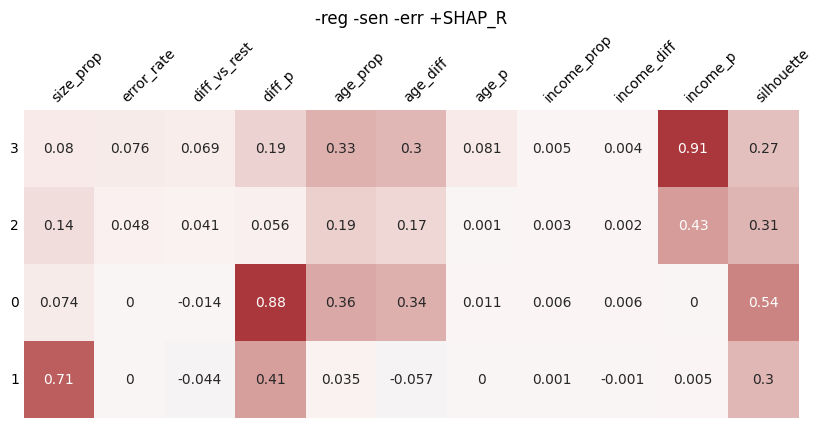

17


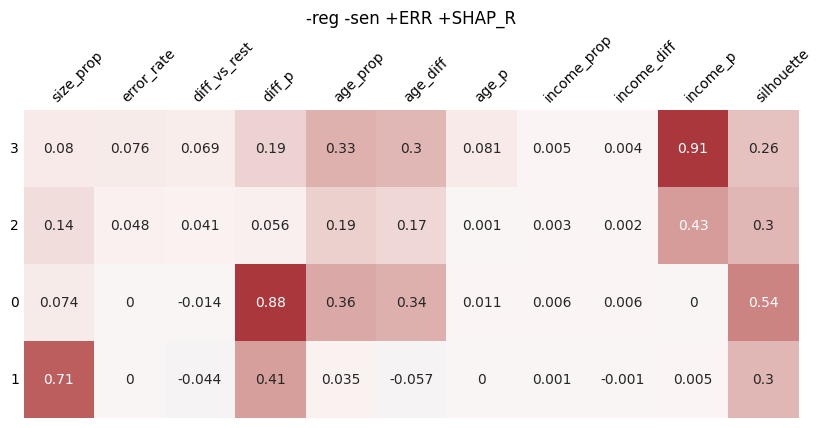

In [33]:
for i in range(0, len(exp_condition)):
  print(i)
  recap = results['cond_recap'][i].sort_values(by=['diff_vs_rest'], ascending=False)
  recap['count'] = recap['count']/recap['count'].sum()
  recap = recap.rename(columns={"count": "size_prop"})
  recap = recap.drop(['n_error','c'], axis=1)

  plt.figure(figsize=(10,4))
  ax = sns.heatmap(recap, annot=True, center=0, cbar=False,
                   cmap=sns.color_palette("vlag", as_cmap=True), robust=True)
  ax.set_title(re.sub(' +', ' ', results['cond_name'][i]))
  ax.xaxis.tick_top()
  ax.set(xlabel="", ylabel="")
  ax.tick_params(axis='x', which='major', length=0)
  ax.tick_params(axis='y', which='major', length=0)
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='left', rotation_mode='anchor')
  plt.yticks(rotation='horizontal')
  plt.savefig('TNFP_Kmeans_'+re.sub(' +', '', results['cond_name'][i])+'.png', bbox_inches='tight', pad_inches=0)
  plt.show()

t-SNE TNFP data

In [34]:
'''for i in range(0, len(exp_condition)):
  plt.figure(figsize=(10,7))
  tsne_plot_wClusters(results['cond_res'][i], title = re.sub(' +', ' ', results['cond_name'][i]),
                      alpha = 0.7, size = 50,
          tsne_columns = REG_scaled + DUMMY_scaled + SHAP_REG_scaled + SHAP_DUMMY_scaled,
          perplexity = 30, learning_rate = 200, n_iter = 250, fig_prefix='TNFP_Kmeans_tSNE_')'''

ValueError: Could not interpret value `Error_Type` for `style`. An entry with this name does not appear in `data`.

<Figure size 1000x700 with 0 Axes>

# TPFN RESULTS

In [35]:
# Set global seed
seed_value = 42
np.random.seed(seed_value)
random.seed(seed_value)

results = {'cond_name': [],
           'cond_descr': [],
           'cond_res': [],
           'cond_recap': []}

for i in range(0, len(exp_condition)):
    # Pass seed to ensure reproducibility
    res = hbac_kmeans(TPFN_data.copy(deep=True),
                      columns_to_use=exp_condition['feature_set'][i],
                      error='errors',
                      min_splittable_cluster_prop=min_splittable_cluster_prop,
                      min_acceptable_cluster_prop=min_acceptable_cluster_prop,
                      min_acceptable_error_diff=min_acceptable_error_diff,
                      max_iter=100,
                      random_state=seed_value)  # Assuming hbac_kmeans accepts random_state

    recap = make_recap(res, exp_condition['feature_set'][i])

    results['cond_name'].append(exp_condition['feature_set_name'][i])
    results['cond_descr'].append(exp_condition['feature_set_descr'][i])
    results['cond_res'].append(res)
    results['cond_recap'].append(recap)

c_n_income: 0.5682539682539685
c_count: 567
rest_n_income: 0.7876272513703995
rest_count: 1277
c_n_income: 0.786963696369637
c_count: 606
rest_n_income: 0.6874798061389339
rest_count: 1238
c_n_income: 0.8038674033149175
c_count: 181
rest_n_income: 0.7110643415514133
rest_count: 1663
c_n_income: 0.7824489795918368
c_count: 490
rest_n_income: 0.6976366322008863
rest_count: 1354
c_n_income: 0.5682539682539685
c_count: 567
rest_n_income: 0.7876272513703995
rest_count: 1277
c_n_income: 0.7849452554744527
c_count: 1096
rest_n_income: 0.6252673796791445
rest_count: 748
c_n_income: 0.8038674033149175
c_count: 181
rest_n_income: 0.7110643415514133
rest_count: 1663
c_n_income: 0.8172413793103448
c_count: 696
rest_n_income: 0.6613240418118467
rest_count: 1148
c_n_income: 0.6635212888377446
c_count: 869
rest_n_income: 0.7706666666666667
rest_count: 975
c_n_income: 0.6544802867383511
c_count: 279
rest_n_income: 0.7318849840255591
rest_count: 1565
c_n_income: 0.8023728813559323
c_count: 590
rest_n_i

Anova

In [44]:
anova_res = make_anova_tests(results)
anova_res_viz = anova_res.set_index('cond_name').drop('cond_descr', axis=1)
anova_res_viz = round(anova_res_viz, 6)
anova_res_viz

,error,age,income
cond_name,,,
+REG +SEN -err -shap,0.0,0.000000,0.0
+REG +SEN +ERR -shap,0.0,0.000000,0.0
+REG +SEN -err +SHAP,0.0,0.000000,0.0
+REG +SEN +ERR +SHAP,0.0,0.000000,0.0
-reg -sen -err +SHAP,0.0,0.000000,0.0
-reg -sen +ERR +SHAP,0.0,0.000000,0.0
-reg +SEN -err -shap,0.0,0.000000,0.0
-reg +SEN +ERR -shap,0.0,0.000000,0.0
-reg +SEN -err +SHAP_S,0.0,0.000000,0.0


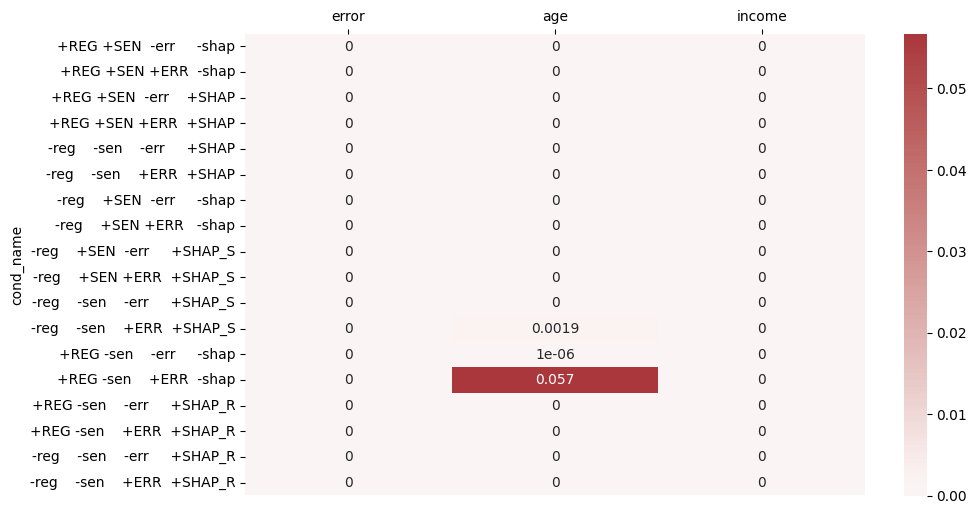

In [45]:
plt.figure(figsize=(10,6))
ax = sns.heatmap(#chi_res_viz,
                 anova_res_viz,annot=True, center=0,
                cmap=sns.color_palette("vlag", as_cmap=True), robust=False)
ax.xaxis.tick_top()
plt.yticks(rotation='horizontal')
plt.show()

## All quality metrics TPFN data

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

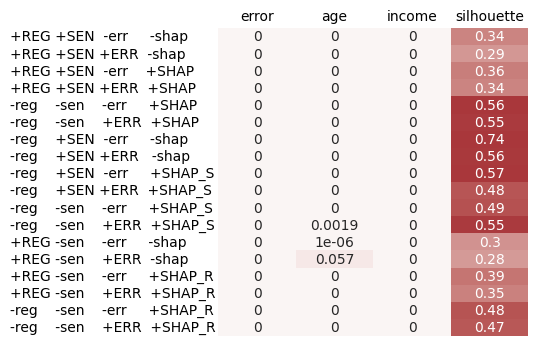

In [49]:
anova_res = make_anova_tests(results)
anova_res_viz = anova_res.set_index('cond_name').drop('cond_descr', axis=1)
anova_res_viz = round(anova_res_viz, 6)
anova_res_viz

all_quali = recap_quali_metrics(#chi_res,
                                anova_res, results, exp_condition)
all_quali_viz = all_quali.set_index('cond_name').drop('cond_descr', axis=1)
all_quali_viz = round(all_quali_viz, 6)
# all_quali_viz
plt.figure(figsize=(4,4))
ax = sns.heatmap(all_quali_viz, annot=True, center=0, cbar=False,
                cmap=sns.color_palette("vlag", as_cmap=True), robust=True)
ax.set(xlabel="", ylabel="")
ax.xaxis.tick_top()
ax.tick_params(axis='x', which='major', length=0)
ax.tick_params(axis='y', which='major', pad=150, length=0)
plt.yticks(ha='left')
plt.savefig('TPFN_Kmeans_BAF.png', bbox_inches='tight', pad_inches=0)
files.download('TPFN_Kmeans_BAF.png')
plt.show()
